## Q DEMDE: Quantum-classical density matrix density estimation

## Libraries

In [3]:
!pip install pennylane

  Using cached PennyLane-0.34.0-py3-none-any.whl (1.6 MB)
  Using cached rustworkx-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached autoray-0.6.8-py3-none-any.whl (49 kB)
  Using cached PennyLane_Lightning-0.34.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.1 MB)


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer
from scipy.stats import norm
import numpy as onp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Classical Prediction with Complex Adaptive RFF

In [5]:
import pylab as pl
from sklearn.kernel_approximation import RBFSampler

def rff_map(x, gamma, n_components, random_state=0):
    rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
    return rbf_feature.fit_transform(x)

def gauss_kernel(x, y, gamma):
    return np.exp(-gamma * (x - y) ** 2)

In [6]:
class QFeatureMapCompAdaptRFF(tf.keras.layers.Layer):

    def __init__(
                 self,
                 input_dim: int,
                 dim: int = 100,
                 gamma: float = 1,
                 random_state = None,
                 gamma_trainable=False,
                 weights_trainable=True,
                 **kwargs
                 ):
        self.g_trainable = gamma_trainable
        self.w_trainable = weights_trainable
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.dim = dim
        self.gamma = gamma
        self.random_state = random_state

    def build(self, input_shape):
        rbf_sampler = RBFSampler(
            gamma=0.5,
            n_components=self.dim,
            random_state=self.random_state)
        x = np.zeros(shape=(1, self.input_dim))
        rbf_sampler.fit(x)
        self.gamma_val = tf.Variable(
            initial_value=self.gamma,
            dtype=tf.float32,
            trainable=self.g_trainable,
            name="rff_gamma")
        self.rff_weights = tf.Variable(
            initial_value=rbf_sampler.random_weights_,
            dtype=tf.float32,
            trainable=self.w_trainable,
            name="rff_weights")
        self.built = True

    def call(self, inputs):
        # Complex Adaptive RFF
        vals = tf.sqrt(self.gamma_val) * tf.matmul(inputs, self.rff_weights)
        vals = tf.complex(tf.cos(vals), -tf.sin(vals))
        vals = vals * tf.cast(tf.sqrt(1. / self.dim), tf.complex64)
        norms = tf.linalg.norm(vals, axis=-1)
        psi = vals / tf.expand_dims(norms, axis=-1)
        return psi


class DMRFF(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 num_rff,
                 gamma=1,
                 random_state=None):
        super().__init__()
        self.rff_layer = QFeatureMapCompAdaptRFF(input_dim=dim_x, dim=num_rff, gamma=gamma, random_state=random_state, gamma_trainable=False)

    def call(self, inputs):

        # Complex Adaptive RFF
        x1 = inputs[:, 0]
        x2 = inputs[:, 1]
        phi1 = self.rff_layer(x1)
        phi2 = self.rff_layer(x2)
        dot = tf.einsum('...i,...i->...', tf.math.conj(phi1), phi2) * tf.einsum('...i,...i->...', tf.math.conj(phi2), phi1)
        dot = tf.cast(dot, tf.float32)
        return dot

def calc_rbf(dmrff, x1, x2):
    return dmrff.predict(np.concatenate([x1[:, np.newaxis, ...],
                                         x2[:, np.newaxis, ...]],
                                        axis=1),
                         batch_size=256)

# 2 Dimensions

In [7]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

In [8]:
def calculate_constant_log_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = np.log(1) - (dimension/2.) *   np.log(2*np.pi*sigma**2)
  return coefficient

In [9]:
def raw_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = 1/(np.size(x_train) * (2*np.pi*sigma**2)**(x_train.shape[1]/2))
  return constant_outside * np.sum(exponential)

In [10]:
def raw_log_kde(x_test, x_train, gamma=1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  constant_outside = np.log(1) - np.log(np.size(x_train)) - (x_train.shape[1]/2) * np.log(2*np.pi*sigma**2)
  return constant_outside + np.log(np.sum(exponential))

In [11]:
def plot(X_train, X_train_density, X_test, X_test_density, name = "dataset"):
    plt.axes(frameon = 0)
    plt.grid()
    plt.scatter(X_test[:,0],  X_test[:,1], c = X_test_density , alpha = .5, s = 3, linewidths= 0.0000001)
    plt.colorbar()
    plt.title('potential 1 dataset')
    plt.savefig(f'{name}.png',dpi = 300)
    plt.show()

# ARC dataset

Weird Gaussians from `Masked Autoregressive Flow for Density Estimation`
***

See the article [here](https://arxiv.org/pdf/1705.07057.pdf) where the distribution of the data is given by the following density:

$$
p(x,y) = \mathcal{N}\left(x_2| 0,4\right) \mathcal{N}\left(x_1|\frac{1}{4}x_2^2,1\right)
$$

## Dataset Generation

In [12]:
dataset_size = 40_000

In [13]:
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(dataset_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(dataset_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

In [14]:
X_densities = x2_dist.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

True densities

In [15]:
x2 = tfp.distributions.Normal(loc = 0., scale = 4.)
x1 = tfp.distributions.Normal(loc = .25 * tf.square(x_samples[:,1]), scale = tf.ones(40_000, dtype=tf.float32))

In [16]:
X_densities = x2.prob(x_samples[:,1]) * x1.prob(x_samples[:,0])

Scatter plot of the data

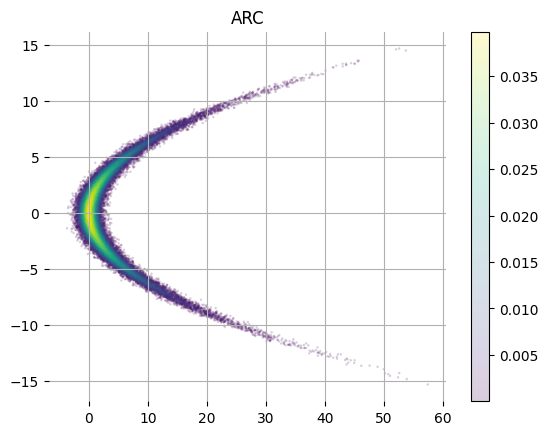

In [17]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x_samples[:,0],  x_samples[:,1], c = X_densities.numpy() , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

To generate mesh grid data that will be used to calculate probability density plot

In [18]:
import scipy.stats

In [19]:
x, y = onp.mgrid[-10:40:(50/120), -15:15:(30/120)]
pos = onp.dstack((x, y))
X_plot = pos.reshape([14400,2])

real_prob = x2_dist.prob(X_plot[:,1]) * scipy.stats.norm(0.25 * np.square(X_plot[:,1]), 1).pdf(X_plot[:,0])

In [20]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)

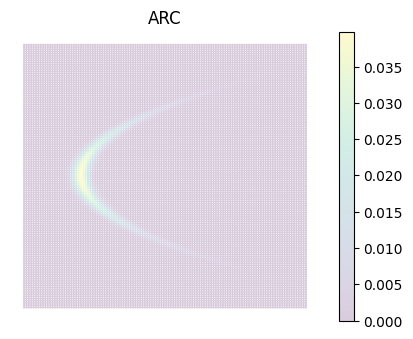

In [21]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(x, y, c = real_prob.numpy().reshape([120,120]) , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('ARC')
plt.yticks([])
plt.xticks([])
plt.savefig('alldensities_arc.png',dpi = 300)
plt.show()

In [22]:
x_samples.shape

TensorShape([40000, 2])

In [23]:
from  sklearn import model_selection
batch_size = 32
train_set, test_set = model_selection.train_test_split(x_samples.numpy(), test_size=0.3)

train_dataset = tf.data.Dataset.from_tensor_slices(train_set)
batched_train_data = train_dataset.batch(batch_size)

# Kernel density estimation baseline

In [24]:
gamma = 2
raw_kde_probability = onp.array([raw_kde(x_temp[np.newaxis,:], train_set, gamma) for x_temp in X_plot])

In [25]:
(1 / real_prob.shape[0]) * onp.sum(onp.abs(real_prob - raw_kde_probability))

0.00038650830586751305

max probability: 0.018038317612506134
min probability: 1.1813052384853958e-197
log max probability: -4.015257027426784
log min probability: -453.44264335835555


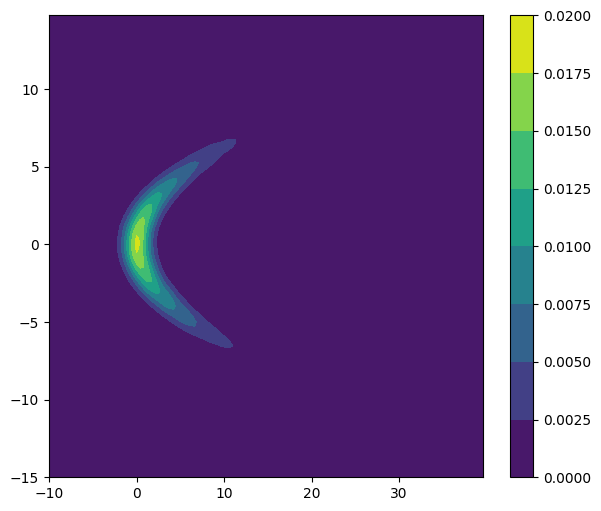

In [26]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", raw_kde_probability.max())
print("min probability:",raw_kde_probability.min())

print("log max probability:", np.log(raw_kde_probability.max()))
print("log min probability:", np.log(raw_kde_probability.min()))

plt.contourf(x, y, raw_kde_probability.reshape([120,120]))
plt.colorbar()
plt.savefig("arcdsdmkde.pdf")

# Q-DEMDE method

In [27]:
sigma_kernel_training = 1
gamma_kernel_training = 1/(2*sigma_kernel_training**2)

print(sigma_kernel_training, gamma_kernel_training)

1 0.5


In [28]:
### training with gaussian training data set
def gaussian_kernel_data(dim_x_param, size_data_param, gamma_train_param = 0.5):
  X_3_temp = np.random.multivariate_normal(mean = np.zeros(2), cov = (1/(2*gamma_train_param*dim_x_param))*np.identity(dim_x_param), size = size_data_param)
  X_4_temp = np.zeros((40_000, 2))
  return X_3_temp, X_4_temp

X_3, X_4 = gaussian_kernel_data(2, 40000)

X_3.shape, X_4.shape

((40000, 2), (40000, 2))

In [29]:
n_rffs = 16
dmrff = DMRFF(dim_x=2, num_rff=n_rffs, gamma=gamma_kernel_training, random_state=onp.random.randint(1, 10000))
dmrff.predict(np.concatenate([X_3[:, np.newaxis, ...],
                                         X_4[:, np.newaxis, ...]],
                                        axis=1),
                         batch_size=256)

157/157 [==============================] - 1s 2ms/step


array([0.45476195, 0.55689645, 0.46550137, ..., 0.8073735 , 0.8155774 ,
       0.5786854 ], dtype=float32)

In [30]:
print(f'Weights: {dmrff.rff_layer.rff_weights}')

Weights: <tf.Variable 'dmrff/q_feature_map_comp_adapt_rff/rff_weights:0' shape=(2, 16) dtype=float32, numpy=
array([[ 2.0277    , -0.61483735, -1.0900071 ,  0.42410478, -0.6712021 ,
         0.6623659 , -1.1702579 , -1.1095395 ,  1.7186608 , -0.39095423,
         1.3130009 , -1.0483606 ,  0.6702453 , -0.01893087, -0.97801274,
         0.09796955],
       [ 0.75166166, -1.604547  ,  0.2959925 ,  0.612051  ,  1.5585753 ,
         1.7800925 , -1.3867471 , -0.13279417,  0.0125532 ,  1.6553301 ,
        -0.74343246,  0.831987  ,  0.09553095,  0.6148742 , -0.09873778,
         0.9624424 ]], dtype=float32)>


In [31]:
weights_qrff = dmrff.rff_layer.rff_weights.numpy()

weights_qrff.mean(), weights_qrff.std()

(0.15708679, 1.0054835)

In [32]:
def gauss_kernel_arr(x, y, gamma_param):
    return onp.exp(-gamma_param * onp.linalg.norm(x - y, axis=1) ** 2)

num_samples = 60_000 # num_samples original = 10000
rnd_idx1 = onp.random.randint(X_3.shape[0],size=(num_samples, ))
rnd_idx2 = onp.random.randint(X_4.shape[0],size=(num_samples, ))
x_train = onp.concatenate([X_3[rnd_idx1][:, onp.newaxis, ...],
                          X_4[rnd_idx2][:, onp.newaxis, ...]],
                         axis=1)

y_train = gauss_kernel_arr(x_train[:, 0, ...], x_train[:, 1, ...], gamma_param=gamma_kernel_training)

x_train.shape, y_train.shape

((60000, 2, 2), (60000,))

In [33]:
epochs = 2
opt = keras.optimizers.Adam(learning_rate=0.001)
dmrff.compile(optimizer=opt, loss="mse")
dmrff.fit(x_train, y_train, batch_size = 5, epochs=epochs)

Epoch 1/2


12000/12000 [==============================] - 22s 2ms/step - loss: 1.5843e-05
Epoch 2/2
12000/12000 [==============================] - 20s 2ms/step - loss: 2.2782e-06


In [34]:
print(f'Weights: {dmrff.rff_layer.rff_weights}')

Weights: <tf.Variable 'dmrff/q_feature_map_comp_adapt_rff/rff_weights:0' shape=(2, 16) dtype=float32, numpy=
array([[ 2.3610697 , -0.40759343, -0.9607282 ,  0.40079686, -1.5004709 ,
         0.79418385, -1.0513034 , -0.9055608 ,  0.93665034, -0.22211584,
         1.2014401 , -1.1848696 ,  0.40737084,  0.24575795, -0.38932377,
         0.34428805],
       [ 0.74766994, -1.8276509 ,  0.26519886,  0.4895569 ,  1.9169072 ,
         1.7911242 , -1.0481704 ,  0.03134483,  0.13600819,  1.6845456 ,
        -0.9998931 ,  0.7850277 ,  0.05407083,  0.03363876, -0.13044329,
         0.6495422 ]], dtype=float32)>


In [35]:
weights_qaff = dmrff.rff_layer.rff_weights.numpy()

weights_qaff.mean(), weights_qaff.std()

(0.14525217, 1.0052054)

## Q-DEMDE QRFF

In [36]:
## Make predictions
# 16 features

gamma_feat = 2.0

weights_rff_temp = weights_qrff

def predict_features(X, var2, gamma_param):
  X_feat = onp.ones((len(X), var2.shape[1]), dtype = onp.complex128)
  X_feat[:, :] = onp.cos(np.sqrt(gamma_param)*(X @ var2)) - 1j*onp.sin(np.sqrt(gamma_param)*(X @ var2))
  X_feat *= onp.sqrt(1/(var2.shape[1]))
  return X_feat

X_feat_train = predict_features(train_set, weights_rff_temp, gamma_feat)
X_feat_test = predict_features(X_plot, weights_rff_temp, gamma_feat)

X_feat_train.shape, X_feat_test.shape

((28000, 16), (14400, 16))

In [37]:
## Training
rho_train = onp.zeros((n_rffs, n_rffs))

for i in range(len(X_feat_train)):
  rho_train = rho_train + onp.outer(X_feat_train[i], onp.conjugate(X_feat_train[i]))

rho_train = rho_train / len(X_feat_train)

(onp.abs(X_feat_train[0])**2).sum()

0.9999999957842798

### QDMKDE circuit

In [38]:
num_qubits_temp = 2*int(np.log2(n_rffs))

dev_dmkde = qml.device("lightning.qubit", wires = 2*num_qubits_temp)

@qml.qnode(dev_dmkde)
def QDMKDE(x_test, U_train, lambda_train):
    upper_wires = [i for i in range(int(num_qubits_temp/2))]
    lower_wires = [i for i in range(int(num_qubits_temp/2), int(num_qubits_temp))]
    qml.MottonenStatePreparation(state_vector=x_test, wires=upper_wires)
    qml.MottonenStatePreparation(state_vector=np.sqrt(lambda_train), wires=lower_wires)
    qml.QubitUnitary(np.conjugate(U_train.T), wires=upper_wires)
    for i in range(int(num_qubits_temp//2)):
      qml.CNOT([lower_wires[i], upper_wires[i]])

    return qml.probs(wires=upper_wires)



In [39]:
## Predicting the density

lambda_train, U_train = np.linalg.eigh(rho_train)
prob_expected_mixed = onp.zeros(len(X_feat_test))

for i in range(len(prob_expected_mixed)):
  prob_expected_mixed[i] = QDMKDE(X_feat_test[i], U_train, lambda_train)[0]

prob_expected_mixed = calculate_constant_qmkde(gamma_feat/2, 2)*prob_expected_mixed


prob_expected_mixed.shape

(14400,)

max probability: 0.06553695523647832
min probability: 0.022285779045103635
log max probability: -2.725141093359447
log min probability: -3.8038065149221003


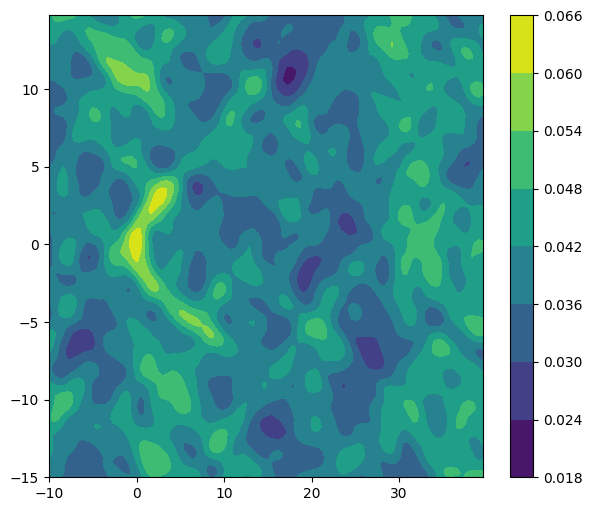

In [40]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", prob_expected_mixed.max())
print("min probability:",prob_expected_mixed.min())

print("log max probability:", np.log(prob_expected_mixed.max()))
print("log min probability:", np.log(prob_expected_mixed.min()))

#plt.contourf(x, y, prob_expected_mixed2_rff.reshape([120,120]))
plt.contourf(x, y, prob_expected_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("arcdmkde.pdf")

### Metrics

In [41]:
## K-L Divergence
from scipy.stats import entropy

# Compute KL Divergence
kl_divergence = entropy(prob_expected_mixed, raw_kde_probability)

print("KL Divergence:", kl_divergence)


KL Divergence: 58.59911523361578


In [42]:
from scipy.stats import spearmanr

# Calculate the ranks of the density values
ranks1 = np.array(raw_kde_probability).argsort().argsort()
ranks2 = prob_expected_mixed.argsort().argsort()

# Calculate the Spearman correlation
spearman_corr, _ = spearmanr(ranks1, ranks2)

print("Spearman Correlation:", spearman_corr)

Spearman Correlation: 0.043869533069072465


In [43]:
# Calculate the absolute differences at each evaluation point
absolute_differences = np.abs(raw_kde_probability - prob_expected_mixed)

# Average the absolute differences
average_error = np.mean(absolute_differences)

print("Mean Average Error:", average_error)

Mean Average Error: 0.03993034525213217


## Q-DEMDE QAFF

In [44]:
## Make predictions
# 16 features

gamma_feat = 2.0

weights_qaff_temp = weights_qaff

def predict_features(X, var2, gamma_param):
  X_feat = onp.ones((len(X), var2.shape[1]), dtype = onp.complex128)
  X_feat[:, :] = onp.cos(np.sqrt(gamma_param)*(X @ var2)) - 1j*onp.sin(np.sqrt(gamma_param)*(X @ var2))
  X_feat *= onp.sqrt(1/(var2.shape[1]))
  return X_feat


X_feat_train = predict_features(train_set, weights_qaff_temp, gamma_feat)
X_feat_test = predict_features(X_plot, weights_qaff_temp, gamma_feat)

X_feat_train.shape, X_feat_test.shape

((28000, 16), (14400, 16))

In [45]:
## Training
rho_train = onp.zeros((n_rffs, n_rffs))

for i in range(len(X_feat_train)):
  rho_train = rho_train + onp.outer(X_feat_train[i], onp.conjugate(X_feat_train[i]))

rho_train = rho_train / len(X_feat_train)

(onp.abs(X_feat_train[0])**2).sum()

0.9999999994618141

### QDMKDE circuit

In [46]:
num_qubits_temp = 2*int(np.log2(n_rffs))

dev_dmkde = qml.device("lightning.qubit", wires = 2*num_qubits_temp)

@qml.qnode(dev_dmkde)
def QDMKDE(x_test, U_train, lambda_train):
    upper_wires = [i for i in range(int(num_qubits_temp/2))]
    lower_wires = [i for i in range(int(num_qubits_temp/2), int(num_qubits_temp))]
    qml.MottonenStatePreparation(state_vector=x_test, wires=upper_wires)
    qml.MottonenStatePreparation(state_vector=np.sqrt(lambda_train), wires=lower_wires)
    qml.QubitUnitary(np.conjugate(U_train.T), wires=upper_wires)
    for i in range(int(num_qubits_temp//2)):
      qml.CNOT([lower_wires[i], upper_wires[i]])

    return qml.probs(wires=upper_wires)



In [47]:
## Predicting the density

lambda_train, U_train = np.linalg.eigh(rho_train)
prob_expected_mixed = onp.zeros(len(X_feat_test))

for i in range(len(prob_expected_mixed)):
  prob_expected_mixed[i] = QDMKDE(X_feat_test[i], U_train, lambda_train)[0]

prob_expected_mixed = calculate_constant_qmkde(gamma_feat/2, 2)*prob_expected_mixed


prob_expected_mixed.shape

(14400,)

max probability: 0.06690145666926618
min probability: 0.025337610601523203
log max probability: -2.704534538254415
log min probability: -3.675465402081895


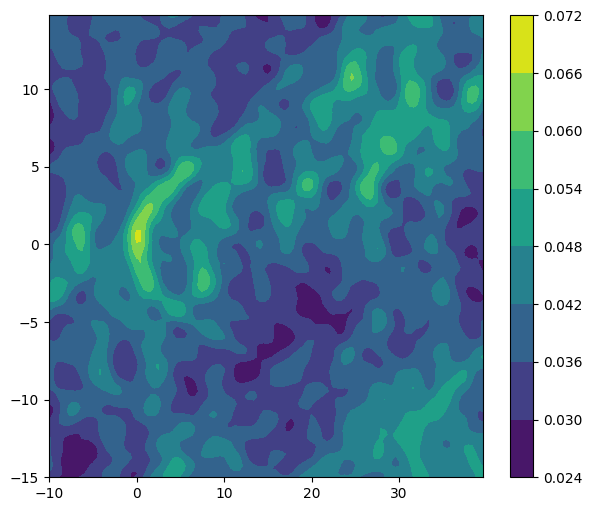

In [48]:
params = {
   'axes.labelsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.0, 6.0]
   }
plt.rcParams.update(params)

print("max probability:", prob_expected_mixed.max())
print("min probability:",prob_expected_mixed.min())

print("log max probability:", np.log(prob_expected_mixed.max()))
print("log min probability:", np.log(prob_expected_mixed.min()))

plt.contourf(x, y, prob_expected_mixed.reshape([120,120]))
plt.colorbar()
plt.savefig("arcdmkde.pdf")

### Metrics

In [49]:
## K-L Divergence
from scipy.stats import entropy

# Compute KL Divergence
kl_divergence = entropy(prob_expected_mixed, raw_kde_probability)

print("KL Divergence:", kl_divergence)


KL Divergence: 54.25682338220468


In [50]:
from scipy.stats import spearmanr

# Calculate the ranks of the density values
ranks1 = np.array(raw_kde_probability).argsort().argsort()
ranks2 = prob_expected_mixed.argsort().argsort()

# Calculate the Spearman correlation
spearman_corr, _ = spearmanr(ranks2, ranks1)

print("Spearman Correlation:", spearman_corr)

Spearman Correlation: 0.3602726152437272


In [51]:
# Calculate the absolute differences at each evaluation point
absolute_differences = np.abs(raw_kde_probability - prob_expected_mixed)

# Average the absolute differences
average_error = np.mean(absolute_differences)

print("Mean Average Error:", average_error)

Mean Average Error: 0.03962608542327181
